In [16]:
!pip install phik scipy

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
import os
import time
import random
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import mlflow
from tqdm.notebook import tqdm

from PM_eq import penman_monteith

Tasks:
- [ ] Remove ERA5 from the code and work with fluxnet meteorology;
- [ ] Start training transformer purely on meteorology data while MOD is being derived;

# Data Processing and Analysis

In [13]:
mod = np.load('./data_v02/MOD_features_all.npy', allow_pickle=True)
mod_idxs = set(np.load('./data_v02/MOD_target_idx_all.npy', allow_pickle=True))

fluxes = pd.read_csv('./data_v02/target_fluxes_MidWest_LE.csv')
keep_idxs = [idx for idx in fluxes.index.tolist() if (idx in mod_idxs)]
fluxes = fluxes.loc[keep_idxs,:]
fluxes['TIMESTAMP'] = pd.to_datetime(fluxes.TIMESTAMP, format='%Y%m%d')
targets = fluxes.LE_F_MDS.values

fluxes

,TIMESTAMP,LE_F_MDS,LE_F_MDS_QC,NETRAD,G_F_MDS,TA_F,VPD_F,WS_F,PA_F,site,H_F_MDS,lat,lon,IGBP
0,2003-05-24,19.2224,1.0000,236.108854,-1.567770,11.213,10.345,1.841,98.421,FLX_US-Wi1,138.470000,46.7305,-91.2329,DBF
1,2003-05-25,24.2024,1.0000,227.120214,-1.126670,12.308,10.551,1.835,98.471,FLX_US-Wi1,112.405000,46.7305,-91.2329,DBF
2,2003-05-26,19.4017,0.9375,249.112486,0.019932,14.778,12.203,1.660,98.656,FLX_US-Wi1,108.937000,46.7305,-91.2329,DBF
3,2003-05-27,23.7468,1.0000,244.104535,1.914990,18.154,15.802,1.532,98.265,FLX_US-Wi1,112.939000,46.7305,-91.2329,DBF
4,2003-05-28,42.2603,0.9375,246.821474,0.114018,14.890,6.921,2.285,97.722,FLX_US-Wi1,85.043500,46.7305,-91.2329,DBF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155271,2003-09-11,55.7628,1.0000,126.808894,7.353920,23.534,10.864,2.743,96.827,AMF_US-Wi3,15.796000,46.6347,-91.0987,DBF
155272,2003-09-13,31.6040,1.0000,65.703064,-8.120460,15.390,2.544,1.353,96.572,AMF_US-Wi3,-8.821360,46.6347,-91.0987,DBF
155273,2003-09-14,54.2463,1.0000,92.268000,-8.471200,13.966,4.375,1.341,96.912,AMF_US-Wi3,-10.596500,46.6347,-91.0987,DBF
155274,2003-09-15,44.2428,1.0000,99.622415,-3.575530,12.401,3.585,1.304,96.968,AMF_US-Wi3,-0.490375,46.6347,-91.0987,DBF


### Energy Balance 

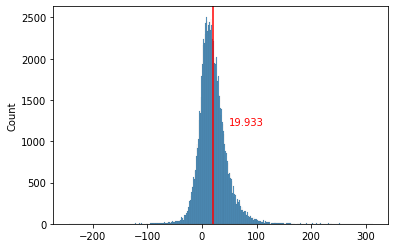

In [14]:
energy_balance = fluxes.NETRAD - fluxes.G_F_MDS - fluxes.H_F_MDS - fluxes.LE_F_MDS
sns.histplot(energy_balance)
plt.axvline(energy_balance.mean(), color='r')
plt.text(50, 1200, round(energy_balance.mean(), 3), color='r')
plt.savefig('./fig/energy_balance_flux.png')

### Feature-Feature Analysis

In [35]:
mod_idxs = pd.Series(list(mod_idxs))
mod_idxs.index = np.arange(len(mod_idxs))
valid_feature_indices = mod_idxs[mod_idxs.isin(fluxes.index)].index.values
mod_features = mod[valid_feature_indices]
mod_features = mod_features[:,:,:-1]#Dropping Coarse_Resolution_Internal_CM

NDVI = (mod_features[:,:,1] - mod_features[:,:,0])/(mod_features[:,:,1] + mod_features[:,:,0])
EVI = (mod_features[:,:,1] - mod_features[:,:,0])/(mod_features[:,:,1] + 6*mod_features[:,:,0] - 7.5*mod_features[:,:,2] + 1)
GNDVI = (mod_features[:,:,1] - mod_features[:,:,3])/(mod_features[:,:,1] + mod_features[:,:,3])
SAVI = (mod_features[:,:,1] - mod_features[:,:,0])/(mod_features[:,:,1] + mod_features[:,:,0] + 0.5)*1.5
ARVI = (mod_features[:,:,1] + mod_features[:,:,2] - 2*mod_features[:,:,0])/(mod_features[:,:,1] + mod_features[:,:,2] + 2*mod_features[:,:,0])

pm_flux = penman_monteith(fluxes, fluxes.index, fluxes, mode='ground').values / 10

features = np.concatenate([mod_features,
                           NDVI[:,:, np.newaxis], EVI[:,:, np.newaxis], GNDVI[:,:, np.newaxis],
                           SAVI[:,:, np.newaxis], ARVI[:,:, np.newaxis]], axis=2)

mod_names = [
          'SensorZenith', 'SensorAzimuth', 'SolarZenith', 'SolarAzimuth',
         'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04',
         'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07', 
]

In [16]:
colors = ['brown', 'darkcyan']
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

### Feature-Target Analysis

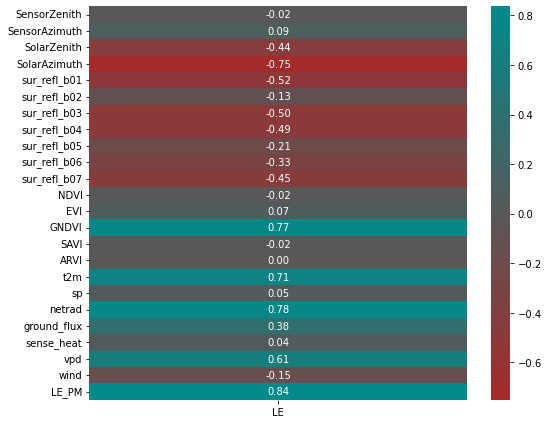

In [36]:
df = pd.DataFrame(data=features.mean(axis=(1)), columns=mod_names+['NDVI', 'EVI', "GNDVI", 'SAVI', 'ARVI'])
df['t2m'] = fluxes.TA_F.values
df['sp'] = fluxes.PA_F.values
df['netrad'] = fluxes.NETRAD.values
df['ground_flux'] = fluxes.G_F_MDS.values
df['sense_heat'] = fluxes.H_F_MDS.values
df['vpd'] = fluxes.VPD_F.values
df['wind'] = fluxes.WS_F.values
df['LE_PM'] = pm_flux
df['LE'] = fluxes.LE_F_MDS.values
# df['LE_ERA'] /= 10
correlation_matrix = df.corr()[["LE"]].iloc[:-1]

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, cbar=True, fmt=".2f")
plt.tight_layout()
plt.savefig('./fig/targets_heatmap_v02.png')
plt.show()

interval columns not set, guessing: ['SensorZenith', 'SensorAzimuth', 'SolarZenith', 'SolarAzimuth', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07', 'NDVI', 'EVI', 'GNDVI', 'SAVI', 'ARVI', 't2m', 'sp', 'netrad', 'ground_flux', 'sense_heat', 'vpd', 'wind', 'LE_PM', 'LE']


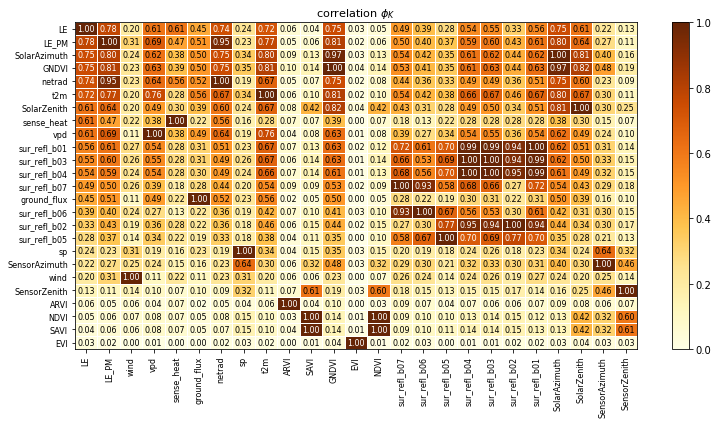

In [37]:
phik_overview = df.phik_matrix().round(2).sort_values('LE')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="YlOrBr",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

# Torch Classes

In [38]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=30):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(30)) / d_model)) #decaying freq
        pe[:, 0::2] = torch.sin(position * div_term) #even
        pe[:, 1::2] = torch.cos(position * div_term) #odd
        self.pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

In [39]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout=0.1):
        super().__init__()
        assert model_dim % num_heads == 0, "model_dim must be divisible by num_heads"

        self.input_proj = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=4*model_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.regressor = nn.Linear(model_dim, 128)
        self.regressor2 = nn.Linear(128, 1)
        self.activation = nn.ReLU()
        self.norm = nn.LayerNorm(model_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(self.norm(x))
        x = x.permute(0, 2, 1)  # Swap to (B, C, T) for pooling

        x = self.pooling(x).squeeze(-1)  # Pool across time
        x = self.regressor(x)
        x = self.regressor2(self.activation(x))  # Output single ET value
        return x

In [40]:
class CustomDataset(Dataset):
    def __init__(self, X, y, x_scaler=None, y_scaler=None, fit_scalers=False):
        self.x_scaler = x_scaler if x_scaler else MinMaxScaler()
        self.y_scaler = y_scaler if y_scaler else MinMaxScaler()

        if fit_scalers: 
            print('fitting')
            N, T, F = X.shape
            X_reshaped = X.reshape(N, -1)  # Flatten time/feature dims
            self.x_scaler.fit(X_reshaped)
            self.y_scaler.fit(y)

        # Transform data
        N, T, F = X.shape
        X_scaled = self.x_scaler.transform(X.reshape(N, -1)).reshape(N, T, F)
        y_scaled = self.y_scaler.transform(y.reset_index().to_numpy()[:,1].reshape(-1, 1))
        
        self.X = torch.tensor(X_scaled, dtype=torch.float32)
        self.y = torch.tensor(y_scaled, dtype=torch.float32)
        self.target_idx = torch.tensor(y.reset_index().to_numpy()[:,0].reshape(-1, 1), dtype=torch.int32)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.target_idx[idx]

In [41]:
def energy_balance(LE_pred, target_idx, mode='ground'):
    #Netrad - G = H + LE
    target_idx = target_idx.flatten().numpy()
    Netrad = torch.tensor(fluxes.loc[target_idx, 'NETRAD'].values, dtype=torch.float32).to(device)
    G = torch.tensor(fluxes.loc[target_idx, 'G_F_MDS'].values, dtype=torch.float32).to(device)
    H = torch.tensor(fluxes.loc[target_idx, 'H_F_MDS'].values, dtype=torch.float32).to(device)
    disclosure = Netrad - G - H - LE_pred
    return disclosure

class Custom_Loss(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.mse = nn.MSELoss()
        self.alpha = alpha  

    def forward(self, predictions, targets, pm_inputs, target_idx):
        predictions = self.revers_scaling(predictions, train_dataset.y_scaler)
        targets = self.revers_scaling(targets, train_dataset.y_scaler)
        
        mse_loss = self.mse(predictions, targets).type(torch.float32)
        disclosure = energy_balance(predictions, target_idx).type(torch.float32)
        
        balance_loss = self.mse(predictions, disclosure).type(torch.float32) 
        total_loss = mse_loss + self.alpha * balance_loss
        return total_loss
    
    def revers_scaling(self, tensor, scaler): #to avoid detachment and losing grads
        data_min = torch.tensor(scaler.data_min_, device="cuda", dtype=torch.float32)
        data_max = torch.tensor(scaler.data_max_, device="cuda", dtype=torch.float32)
        return tensor * (data_max - data_min) + data_min 

# Training

In [42]:
X_train, X_test, y_train, y_test = train_test_split(features, fluxes, test_size=0.3, random_state=42)

y_train = y_train.LE_F_MDS#reshape(-1, 1)
y_test = y_test.LE_F_MDS#reshape(-1, 1)

x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
N, T, F = X_train.shape
x_scaler.fit(X_train.reshape(N, -1))
y_scaler.fit(y_train.reset_index().to_numpy()[:,1].reshape(-1, 1))

train_dataset = CustomDataset(X_train, y_train, x_scaler, y_scaler, fit_scalers=False)
test_dataset = CustomDataset(X_test, y_test, x_scaler, y_scaler, fit_scalers=False)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epoch = 50

input_dim = 16 #num features
model_dim = 1000
num_heads = 250
num_layers = 8 #8
dropout=0.3

In [63]:
model = TransformerEncoder(input_dim, model_dim, num_heads, num_layers, dropout).to(device)
#model.load_state_dict(torch.load(f'./models/transformer_state_{num_layers}_{num_heads}_{model_dim}.pth', weights_only=True))

In [64]:
print(f'The number of model params: {sum(p.numel() for p in model.parameters())}')

The number of model params: 96251257


In [65]:
criteria = Custom_Loss(alpha=0)
optimizer = optim.AdamW(model.parameters(), lr=1e-4) #4
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoch, eta_min=0)

In [66]:
experiment_name = "Transformer_FLUX_MODIS_" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [67]:
if os.path.exists(f"runs/{experiment_name}"):
    raise ValueError(f"Experiment '{experiment_name}' already exists! Choose a different name.")
else:
    writer = SummaryWriter(log_dir=f"runs/{experiment_name}")
    writer.add_text("Model Description", "This model is trained on the MODIS + FLUXNET (meteorology) dataset. ")
    hparams = {
        "input_dim": input_dim,
        "model_dim": model_dim,
        "num_heads": num_heads,
        "num_layers": num_layers,
        "dropout": dropout,
        "learning_rate": 1e-4,
        "batch_size": 128,
        "optimizer": "AdamW",
        "scheduler": "CosineAnnealingLR",
    }

In [ ]:
best = -np.inf
t0 = time.time()
for epoch in tqdm(range(num_epoch)):
    model.train()
    for x, y, idx in train_loader:
        x, y = x.to(device), y.squeeze().to(device)
        pred = model(x).squeeze()
        error = criteria(pred, y.to(device), x.to(device), idx)

        optimizer.zero_grad()
        error.backward()
        optimizer.step()
        scheduler.step()
        writer.add_scalar("Loss/train", error, epoch)
    if epoch % 5 == 0:
        model.eval()
        test_preds = []
        test_true = []
        test_x = []
        test_idx = []
        with torch.no_grad():
            for x, y, idx in test_loader:
                x, y = x.to(device), y.squeeze().to(device)
                preds = model(x).squeeze()
                test_preds.append(preds.detach().cpu())
                test_true.append(y.detach().cpu())
                test_x.append(x.detach().cpu())
                test_idx.append(idx)
        test_preds = torch.cat(test_preds).squeeze()
        test_true = torch.cat(test_true).squeeze()
        test_x = torch.cat(test_x).squeeze()
        test_idx = torch.cat(test_idx).squeeze()
        
        test_loss = criteria(test_preds.to(device), test_true.to(device), test_x.to(device), test_idx).item()
        r2 = r2_score(test_true.detach().cpu().numpy(), test_preds.detach().cpu().numpy())
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("R2/test", r2, epoch)
        
        best_old = best
        best = min(test_loss, best)
        if abs(best) > best_old:
            torch.save(model.state_dict(), f'./models/{experiment_name}.pth') #0.6532
            writer.add_text("Checkpoint", "Saved model at epoch {}".format(epoch))
        print(f'Test RMSE: {test_loss**0.5:0.3f}\t\tTest R2: {r2:0.4f}\t\t{round((time.time()-t0)/60,3)} min')
writer.close()

Test RMSE: 27.734		Test R2: 0.5210		2.573 min


# Logs

5 epochs - 0.64